# Permutation Tests

In [1]:
import sys
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.dwd_data import DWD_Dataset, Feature

In [2]:
FIG_SAVE_BASE_PATH = "../docs/report/fig/"

In [3]:
dataset_model_1 = DWD_Dataset(source_path="../data/dwd", feature=Feature.PRECIPITATION, model=1)
dataset_model_2 = DWD_Dataset(source_path="../data/dwd", feature=Feature.PRECIPITATION, model=2)

## H0: The forecast is not prone to overestimate nor underestimate precipitation 

In [4]:
merge1 = dataset_model_1.get_merge()
merge2 = dataset_model_2.get_merge()

# Bootstrap
N_BOOT = 500

boot_mean_errors = np.empty((N_BOOT, 2))
for i in tqdm(range(N_BOOT)):
    # concatenate real values as forecasts ....
    concat = np.concatenate(
        [merge1["precipitation_forecast"].values.copy(), merge1["precipitation_real"].values.copy()]
    )
    # ... shuffle it because it should not make a difference if I take the value of a perfect model or the real life data...
    shuffle(concat)
    # ... and take the mean difference
    shuffle_error = concat[: len(merge1)] - concat[len(merge1) :]
    boot_mean_errors[i, 0] = shuffle_error.mean()

    concat = np.concatenate(
        [merge2["precipitation_forecast"].values.copy(), merge2["precipitation_real"].values.copy()]
    )
    shuffle(concat)
    shuffle_error = concat[: len(merge2)] - concat[len(merge2) :]
    boot_mean_errors[i, 1] = shuffle_error.mean()

100%|██████████| 500/500 [00:45<00:00, 11.09it/s]


In [5]:
mean_error1 = merge1["precipitation_error"].mean()
mean_error2 = merge2["precipitation_error"].mean()

/home/robin/miniconda3/envs/DataLiteracy/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6831: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/robin/miniconda3/envs/DataLiteracy/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6832: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

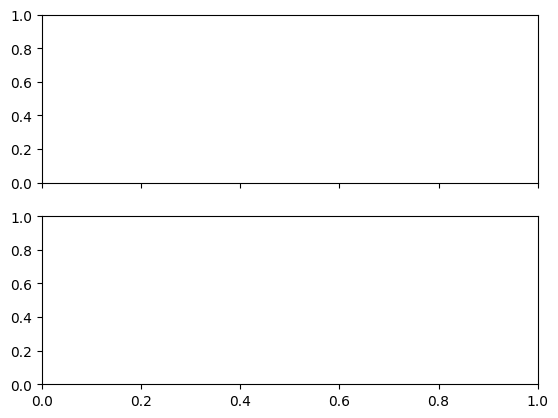

In [6]:
# for model 1
fig, axs = plt.subplots(nrows=2, sharex=True)
counts, bins, _ = axs[0].hist(boot_mean_errors[:, 0])
counts = counts / counts.sum()
axs[0].axvline(mean_error1, c="orange")
cdf = np.cumsum(counts)
axs[1].plot(bins[:-1],1 - cdf)
axs[1].axvline(mean_error1, c="orange")

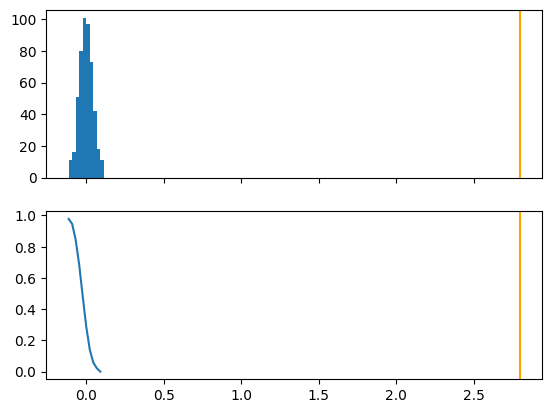

In [ ]:
# for model 2
fig, axs = plt.subplots(nrows=2, sharex=True)
counts, bins, _ = axs[0].hist(boot_mean_errors[:, 1])
counts = counts / counts.sum()
axs[0].axvline(mean_error2, c="orange")
cdf = np.cumsum(counts)
axs[1].plot(bins[:-1],1 - cdf)
axs[1].axvline(mean_error2, c="orange")

Conclusion: Test results are very significant. We will reject reject H0

Recall the difference plots over time steps into the future.  
Are the coefficients we found for the linear trend significant?

## H0: There is no difference between the error at t versus the error at t + h with t >= 0 and h > 0. 

In [ ]:
merge1 = dataset_model_1.get_merge()

call_times = sorted(merge1["call_time"].unique())
station_ids = sorted(merge1["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge1[(merge1["call_time"] == call_time) & (merge1["station_id"] == station_id)]
        
        if len(sub_df_forecast) < 72:
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"].values[:72])
    
    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_1 = np.stack(result)



In [ ]:
merge2 = dataset_model_2.get_merge() 

call_times = sorted(merge2["call_time"].unique())
station_ids = sorted(merge2["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge2[(merge2["call_time"] == call_time) & (merge2["station_id"] == station_id)]
        
        if len(sub_df_forecast) < 56:  # 56 is how many samples are expected in a forecast of model 2
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"][:56])
    
    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_2 = np.stack(result)

In [ ]:
station_errors_model_1 = error_mat_model_1.mean(axis=0)
forecast_error_model_1 = station_errors_model_1.mean(axis=0)

station_errors_model_2 = error_mat_model_2.mean(axis=0)
forecast_error_model_2 = station_errors_model_2.mean(axis=0)

In [ ]:
N_BOOT = 1000000
x = np.arange(forecast_error_model_1.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
X_1 = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T

x = np.arange(forecast_error_model_2.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
X_2 = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T


coefs = np.empty((N_BOOT, x_aug.shape[1], 2))
for i in tqdm(range(N_BOOT)):
    # shape: (num_pred_steps, num_stations)
    temp = forecast_error_model_1.copy()
    np.random.shuffle(temp)
    regression_coef = X_1 @ temp
    coefs[i, :, 0] = regression_coef

    temp = forecast_error_model_2.copy()
    np.random.shuffle(temp)
    regression_coef = X_2 @ temp
    coefs[i, :, 1] = regression_coef

100%|██████████| 1000000/1000000 [00:06<00:00, 154795.69it/s]


Significance level of mean error on b = 3.075973587815694 = 0.7887615
Significance level of mean error on m = -0.00214683342972818 = 0.7365539999999999


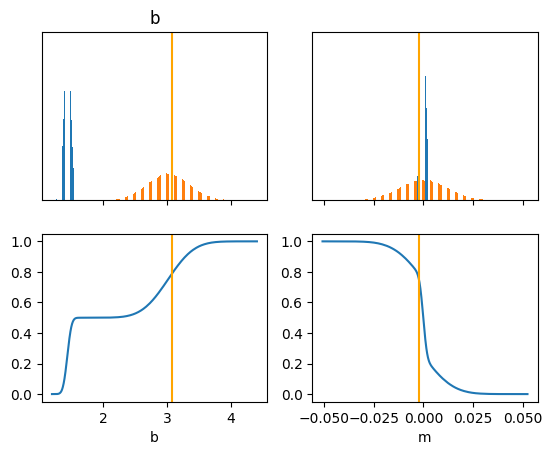

In [ ]:
fig, axs = plt.subplots(ncols=2)
b_counts, b_bins = np.histogram(coefs[:, 0], bins=1000)
m_counts, m_bins = np.histogram(coefs[:, 1], bins=1000)

axs[0, 0].hist(coefs[:, 0], bins=b_bins)
axs[0, 0].axvline(regression_coef[0], c="orange")
axs[0, 0].set_title("b")
axs[0, 0].get_yaxis().set_visible(False)
axs[0, 0].set_xticklabels([])
axs[0, 1].hist(coefs[:, 1], bins=m_bins)
axs[0, 1].axvline(regression_coef[1], c="orange")
axs[0, 1].get_yaxis().set_visible(False)
axs[0, 1].set_xticklabels([])
b_cdf = np.cumsum(b_counts) / np.sum(b_counts)
axs[1, 0].plot(b_bins[:-1], b_cdf)
axs[1, 0].axvline(regression_coef[0], c="orange")
axs[1, 0].set_xlabel("b")
m_cdf = np.cumsum(m_counts) / np.sum(m_counts)
axs[1, 1].plot(m_bins[:-1], (1 - m_cdf))
axs[1, 1].axvline(regression_coef[1], c="orange")
axs[1, 1].set_xlabel("m")

# find index 
bins = np.stack([b_bins, m_bins]).T
index = np.argmax((bins - regression_coef) > 0, axis=0)
# TODO: left or right bucket for p-value -> or linear interpolation
print(f"Significance level of mean error on b = {regression_coef[0]} = {b_cdf[index[0]]}") 
print(f"Significance level of mean error on m = {regression_coef[1]} = {(1 - m_cdf)[index[1]]}")